# Vision Zero, Chicago, modeling car crashes with injuries.

# Overview
I was hired by a government agency CMAP (Chicago Metropolitan Agency for Planning) to create a model which predicts injuries during car crashes based on information collected by Chicago Police Department (CPD). I  concluded that there are many features that determine the oucome of car crash(overall 200 features, only 31 were used in our model), some of them: type of crash , day, season, time, type of crash, are there injuried people, phyesical imparement factors(drugs, alchogol, distraction etc), speed limit, weather, lightning and road conditions etc .

To acheive my goal, I trained more than 100 models and tuned hyperparameters, model types that were used: 
- LogisticRegression
- KNN
- Naive Bayes(different type) 
- DecisionTree
- Random Forest
- ADA Boost
- Gradient boost
- XGB Classifier


# Business Understanding
Our stakeholder wants to understand what factors of crash influence on injury outcome as the last possible outcome. They perfectly understand that car crashes will be happening but they want to reduce the number of injuries because individual health prevails under public mobility. 

# Data

1) Database Traffic Crashes - Crashes. Years: 2017 - now
Provided by City of Chicago

https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if 

2) Database Traffic Crashes - People. Years: 2017 - now
Provided by City of Chicago

https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d

3) Database Traffic Crashes - Vehicles. Years: 2017 - now
Provided by City of Chicago  

https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3

##### In my research I used data for 2021 year.

# Metrics
#### Our project will answer following question:
What factors influence injuries?

#### Hypothesis:
H0 - car crashes with injuries are random

HA - There is a significant dependancy between injuries and the features of dataset

#### TP, TN, FP, FN definition
TP - we predict car crash with injury and it actually happened.

TN - we predicted that there is no injury and there was no injury,

FP - We predicted injury but there was no injury in real life

FN - We predicted that there will be no injury but it happened


#### Metrics used  
To compare models we will focus on 2 major metrics:

Accuracy - how good we can predict TP and TN. General metrics that will show model performance.

Recall - Health of people is our priority, we will be focused to minimize FN, so we can consider as much real car crashes with injuries in our model as possible, even if our model mark some car crashes with injuries but there will be no such. From the other side we need consider accuracy.


# Data Understanding
#### Sources of data:
1) Database Traffic Crashes - Crashes. Years: 2017 - now
Covers: Main characteristics of car crash.
Provided by City of Chicago 
https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if

2) Database Traffic Crashes - People. Years: 2017 - now
Covers: People/drivers involved in car crash.
Provided by City of Chicago 
https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d

3) Database Traffic Crashes - Vehicles. Years: 2017 - now
Covers: Vehicles involved in car crash.
Provided by City of Chicago 
https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3

#### Main dataset contains the following columns:


# Data Cleaning
### Importing required modules

In [156]:
# Work with data
import pandas as pd
import numpy as np
from scipy import stats as stats

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

#Modeling

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB, GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_curve, plot_roc_curve, roc_auc_score, accuracy_score, recall_score, f1_score
from xgboost import XGBClassifier

# Keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.regularizers import l2

#Other
import pickle
import time
import gzip
import os, shutil 
from zipfile import ZipFile
import scipy
from PIL import Image
from scipy import ndimage


from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
simplefilter(action='ignore', category= FutureWarning)
simplefilter(action='ignore', category= ConvergenceWarning)
simplefilter(action='ignore', category= FitFailedWarning)
simplefilter(action='ignore', category= UserWarning)





np.random.seed(123)

  




### Data preparation

Below we create three objects representing the existing directories: `data/normal/` as `data_normal_dir` and `data/pneumonia/` as `data_pneumonia_dir`, `data/test/normal/` as `test/normal` and `data/test/pneumonia/` as `test/pneumonia`. We will create a new directory `split/` as `new_dir`, where we will split the dataset in three groups (or three subdirectories): `train`, `test`, and `validation`, each containing `normal` and `pneumonia` subfolders. The final desired structure is represented below: 

![title](images/folder_structure.png)

In [2]:
data_normal_dir = 'data/normal/'
data_pneumonia_dir = 'data/pneumonia/'
new_dir = 'data/split/'
data_test_normal_dir = 'data/test/normal/'
data_test_pneumonia_dir = 'data/test/pneumonia/'

In [3]:
# Train set
imgs_normal = [file for file in os.listdir(data_normal_dir) if file.endswith('.jpeg')]
imgs_pneumonia = [file for file in os.listdir(data_pneumonia_dir) if file.endswith('.jpeg')]
# Test set
imgs_normal_test = [file for file in os.listdir(data_test_normal_dir) if file.endswith('.jpeg')]
imgs_pneumonia_test = [file for file in os.listdir(data_test_pneumonia_dir) if file.endswith('.jpeg')]

In [4]:
os.listdir(data_normal_dir)[0]

'NORMAL-2552119-0002.jpeg'

In [5]:
print("Train set:")
print('There are', len(imgs_normal), 'normal images, image name example,',os.listdir(data_normal_dir)[0])
print('There are', len(imgs_pneumonia), 'pneumonia images, image name example,',os.listdir(data_pneumonia_dir)[0])
print("Test set:")
print('There are', len(imgs_normal_test), 'normal images, image name example,',os.listdir(data_test_normal_dir)[0])
print('There are', len(imgs_pneumonia_test), 'pneumonia images, image name example,',os.listdir(data_test_pneumonia_dir)[0])


Train set:
There are 620 normal images, image name example, NORMAL-2552119-0002.jpeg
There are 667 pneumonia images, image name example, BACTERIA-292199-0002.jpeg
Test set:
There are 234 normal images, image name example, NORMAL-8698006-0001.jpeg
There are 390 pneumonia images, image name example, VIRUS-2040583-0001.jpeg


Make new split directory

In [6]:
os.mkdir(new_dir)

Create new directories

In [7]:
# Define path
train_folder = os.path.join(new_dir, 'train')
train_normal = os.path.join(train_folder, 'normal')
train_pneumonia = os.path.join(train_folder, 'pneumonia')

test_folder = os.path.join(new_dir, 'test')
test_normal = os.path.join(test_folder, 'normal')
test_pneumonia = os.path.join(test_folder, 'pneumonia')

val_folder = os.path.join(new_dir, 'validation')
val_normal = os.path.join(val_folder, 'normal')
val_pneumonia = os.path.join(val_folder, 'pneumonia')

In [8]:
# Check that path is ok
train_pneumonia

'data/split/train/pneumonia'

In [9]:
# Create directories
os.mkdir(test_folder)
os.mkdir(test_normal)
os.mkdir(test_pneumonia)

os.mkdir(train_folder)
os.mkdir(train_normal)
os.mkdir(train_pneumonia)

os.mkdir(val_folder)
os.mkdir(val_normal)
os.mkdir(val_pneumonia)

Copy images

In [10]:
# Setting size of validation set
val_set = 150

In [11]:
# train normal
imgs_train_norm = imgs_normal[:len(os.listdir(data_normal_dir))-val_set]
for img in imgs_train_norm:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(train_normal, img)
    shutil.copyfile(origin, destination)
# train pneumonia
imgs_train_pneumonia = imgs_pneumonia[:len(os.listdir(data_pneumonia_dir))-val_set]
for img in imgs_train_pneumonia:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(train_pneumonia, img)
    shutil.copyfile(origin, destination)


In [12]:
len(imgs_train_pneumonia)

517

In [13]:
# validation set
imgs = imgs_normal[len(os.listdir(data_normal_dir))-val_set:]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(val_normal, img)
    shutil.copyfile(origin, destination)

imgs = imgs_pneumonia[len(os.listdir(data_normal_dir))-val_set:]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(val_pneumonia, img)
    shutil.copyfile(origin, destination)

In [14]:
# test normal
imgs = imgs_normal_test
for img in imgs:
    origin = os.path.join(data_test_normal_dir, img)
    destination = os.path.join(test_normal, img)
    shutil.copyfile(origin, destination)
# test pneumonia
imgs = imgs_pneumonia_test
for img in imgs:
    origin = os.path.join(data_test_pneumonia_dir, img)
    destination = os.path.join(test_pneumonia, img)
    shutil.copyfile(origin, destination)   


Check the folders:

In [24]:
# Train images
train_img_number = len(os.listdir(train_normal)) + len(os.listdir(train_pneumonia))
# Validation images
val_img_number = len(os.listdir(val_normal)) + len(os.listdir(val_pneumonia))
# Test images
test_img_number = len(os.listdir(test_normal)) + len(os.listdir(test_pneumonia))


In [26]:
print('Training set:',train_img_number, "images" )
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print('Validation set:', val_img_number, "images" )
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')
print('Test set:', test_img_number, 'images')
print('There are', len(os.listdir(test_normal)), 'normal images in the test set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the test set')


Training set: 987 images
There are 470 normal images in the training set
There are 517 pneumonia images in the training set
Validation set: 347 images
There are 150 normal images in the validation set
There are 197 pneumonia images in the validation set
Test set: 624 images
There are 234 normal images in the test set
There are 390 pneumonia images in the test set


### Setting up help functions:

##### Results visualization:

In [119]:
def visualize_training_results(results):
    fig, (left, right) = plt.subplots(1,2, figsize = (16,6))
    history = results.history
    left.plot(history['val_loss'], label = "val loss")
    left.plot(history['loss'], label = "loss")
    left.set_title('Loss')
    left.set_xlabel('Epochs')
    left.set_ylabel('Loss')
    left.legend()
    
    right.plot(history['val_accuracy'], label = "val accuracy")
    right.plot(history['accuracy'], label = "accuracy")
    right.set_title('Accuracy')
    right.set_xlabel('Epochs')
    right.set_ylabel('Accuracy')
    right.legend()

    plt.show()
    
    

In [217]:
def visualize_training_results2(results):
    fig, (left, right) = plt.subplots(1,2, figsize = (16,6))
    history = results.history
    left.plot(history['val_loss'], label = "val loss")
    left.plot(history['loss'], label = "loss")
    left.set_title('Loss')
    left.set_xlabel('Epochs')
    left.set_ylabel('Loss')
    left.legend()
    
    right.plot(history['val_acc'], label = "val acc")
    right.plot(history['acc'], label = "acc")
    right.set_title('Accuracy')
    right.set_xlabel('Epochs')
    right.set_ylabel('Accuracy')
    right.legend()

    plt.show()

### Use a densely connected network as a baseline

In [132]:
# get all the data in the directory split/train, and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size= train_img_number)

# get all the data in the directory split/validation, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = val_img_number)

# get all the data in the directory split/test, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = test_img_number) 





Found 987 images belonging to 2 classes.
Found 347 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [133]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [134]:
# Explore dataset
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 987
Number of testing samples: 624
Number of validation samples: 347
train_images shape: (987, 64, 64, 3)
train_labels shape: (987, 2)
test_images shape: (624, 64, 64, 3)
test_labels shape: (624, 2)
val_images shape: (347, 64, 64, 3)
val_labels shape: (347, 2)


In [135]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(987, 12288)
(624, 12288)
(347, 12288)


In [136]:
train_y = np.reshape(train_labels[:,0], (train_img_number,1))
test_y = np.reshape(test_labels[:,0], (test_img_number,1))
val_y = np.reshape(val_labels[:,0], (val_img_number,1))

In [137]:

np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],))) # 2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [138]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_base = model.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/20
31/31 [==============================] - 1s 11ms/step - loss: 0.6914 - accuracy: 0.5471 - val_loss: 0.6783 - val_accuracy: 0.7061
Epoch 2/20
31/31 [==============================] - 0s 7ms/step - loss: 0.6597 - accuracy: 0.6717 - val_loss: 0.6146 - val_accuracy: 0.5850
Epoch 3/20
31/31 [==============================] - 0s 7ms/step - loss: 0.6342 - accuracy: 0.6707 - val_loss: 0.6612 - val_accuracy: 0.4928
Epoch 4/20
31/31 [==============================] - 0s 7ms/step - loss: 0.6428 - accuracy: 0.6403 - val_loss: 0.6577 - val_accuracy: 0.5245
Epoch 5/20
31/31 [==============================] - 0s 7ms/step - loss: 0.6217 - accuracy: 0.7842 - val_loss: 0.6241 - val_accuracy: 0.6657
Epoch 6/20
31/31 [==============================] - 0s 7ms/step - loss: 0.5678 - accuracy: 0.8531 - val_loss: 0.5613 - val_accuracy: 0.7896
Epoch 7/20
31/31 [==============================] - 0s 8ms/step - loss: 0.5044 - accuracy: 0.8521 - val_loss: 0.4941 - val_accuracy: 0.8444
Epoch 8/20
31/31 [=

In [139]:
results_train = model.evaluate(train_img, train_y)

31/31 [==============================] - 0s 3ms/step - loss: 0.1110 - accuracy: 0.9645


In [140]:
results_test = model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 2ms/step - loss: 0.3524 - accuracy: 0.8462


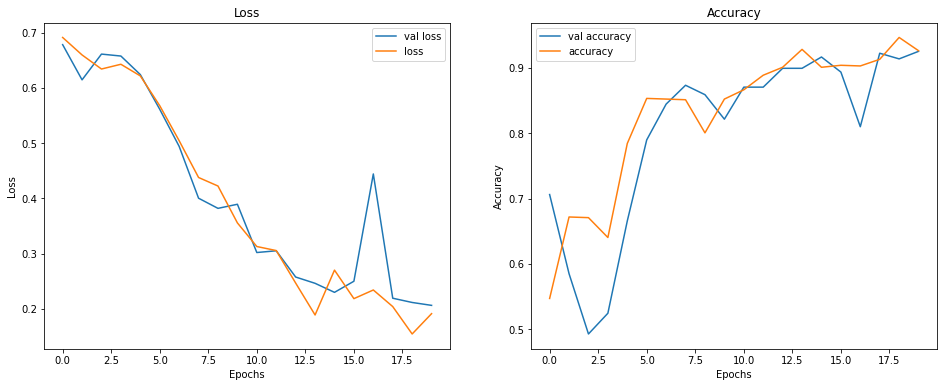

In [141]:
visualize_training_results(history_base)

In [149]:
results_test = model.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test[1]}")

20/20 [==============================] - 0s 2ms/step - loss: 0.3524 - accuracy: 0.8462
Test set results accuracy 0.8461538553237915


### Baseline + regulization

We will use L2 regulization in each layer, to reduce overfitting.
Will try different L2 coefficients to determine the best one

In [175]:
L2_list = [0.001, 0.01, 0.1, 1]

In [178]:
L2_fin = []
for L2 in L2_list:
    model2 = models.Sequential()
    model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2))) 
    model2.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2)))
    model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2)))
    model2.add(layers.Dense(1, activation='sigmoid'))
    model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 0)
    results_test = model2.evaluate(test_img, test_y)
    L2_fin.append((L2, results_test[1]))
        


20/20 [==============================] - 0s 2ms/step - loss: 0.6834 - accuracy: 0.6250


In [186]:
L2_best = sorted(L2_fin, key = lambda x: x[1], reverse = True)[0][0]
print("Best L2 regulization parameter:", L2_best)

Best L2 regulization parameter: 0.01


In [189]:
model2 = models.Sequential()
model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 1)


Epoch 1/20
31/31 [==============================] - 1s 9ms/step - loss: 2.1561 - accuracy: 0.5856 - val_loss: 2.0802 - val_accuracy: 0.6340
Epoch 2/20
31/31 [==============================] - 0s 6ms/step - loss: 2.0635 - accuracy: 0.6727 - val_loss: 1.9572 - val_accuracy: 0.8530
Epoch 3/20
31/31 [==============================] - 0s 7ms/step - loss: 1.9285 - accuracy: 0.7903 - val_loss: 2.4624 - val_accuracy: 0.4380
Epoch 4/20
31/31 [==============================] - 0s 6ms/step - loss: 1.9083 - accuracy: 0.7518 - val_loss: 2.0618 - val_accuracy: 0.6110
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 1.7709 - accuracy: 0.8490 - val_loss: 1.7207 - val_accuracy: 0.8818
Epoch 6/20
31/31 [==============================] - 0s 6ms/step - loss: 1.7729 - accuracy: 0.8359 - val_loss: 1.6908 - val_accuracy: 0.8818
Epoch 7/20
31/31 [==============================] - 0s 6ms/step - loss: 1.6364 - accuracy: 0.8997 - val_loss: 1.9347 - val_accuracy: 0.7320
Epoch 8/20
31/31 [==

In [190]:
results_train = model2.evaluate(train_img, train_y)

31/31 [==============================] - 0s 2ms/step - loss: 1.3625 - accuracy: 0.9179


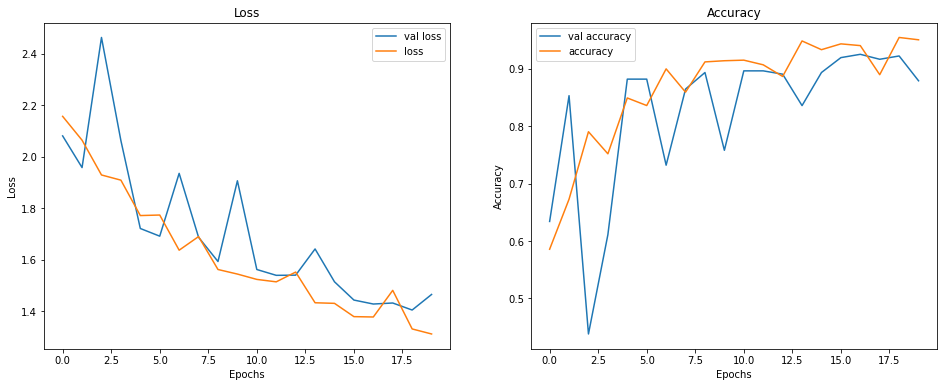

In [191]:
visualize_training_results(history_model2)

In [192]:
results_test = model2.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test[1]}")

20/20 [==============================] - 0s 2ms/step - loss: 1.6603 - accuracy: 0.8173
Test set results accuracy 0.817307710647583


### Baseline + regulization + Dropout

In [193]:
model3 = models.Sequential()
model3.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dense(1, activation='sigmoid'))


In [194]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_model3 = model3.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/20
31/31 [==============================] - 1s 11ms/step - loss: 2.1751 - accuracy: 0.5167 - val_loss: 2.1353 - val_accuracy: 0.5677
Epoch 2/20
31/31 [==============================] - 0s 6ms/step - loss: 2.1318 - accuracy: 0.5441 - val_loss: 2.1060 - val_accuracy: 0.5793
Epoch 3/20
31/31 [==============================] - 0s 7ms/step - loss: 2.0779 - accuracy: 0.6251 - val_loss: 2.0552 - val_accuracy: 0.5879
Epoch 4/20
31/31 [==============================] - 0s 7ms/step - loss: 2.0217 - accuracy: 0.6900 - val_loss: 2.0401 - val_accuracy: 0.8300
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 1.9781 - accuracy: 0.7477 - val_loss: 1.9422 - val_accuracy: 0.7291
Epoch 6/20
31/31 [==============================] - 0s 6ms/step - loss: 1.9141 - accuracy: 0.7974 - val_loss: 2.0537 - val_accuracy: 0.5735
Epoch 7/20
31/31 [==============================] - 0s 6ms/step - loss: 1.8716 - accuracy: 0.8389 - val_loss: 1.8555 - val_accuracy: 0.8818
Epoch 8/20
31/31 [=

In [195]:
results_train3 = model3.evaluate(train_img, train_y)

31/31 [==============================] - 0s 2ms/step - loss: 1.4307 - accuracy: 0.9210


In [196]:
results_test3 = model3.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test3[1]}")

20/20 [==============================] - 0s 2ms/step - loss: 1.6121 - accuracy: 0.8285
Test set results accuracy 0.8285256624221802


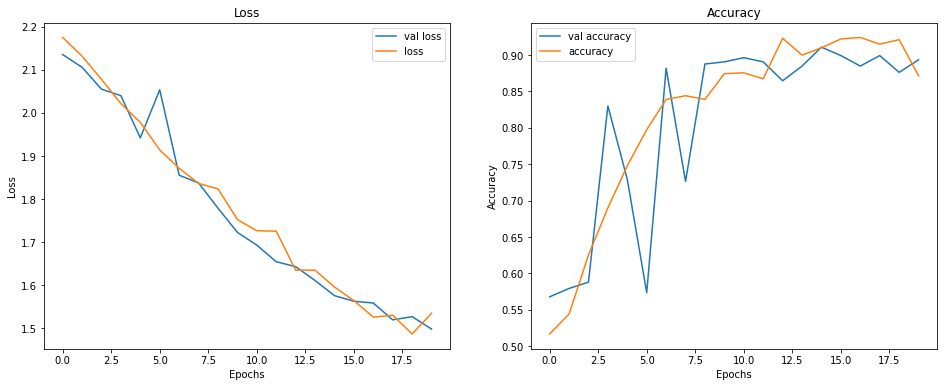

In [197]:
visualize_training_results(history_model3)

### Baseline + regulization + Dropout + Adam optimizer

In [198]:
model4 = models.Sequential()
model4.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dense(1, activation='sigmoid'))

In [199]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_model4 = model4.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/20
31/31 [==============================] - 1s 11ms/step - loss: 1.9114 - accuracy: 0.4772 - val_loss: 1.4755 - val_accuracy: 0.5677
Epoch 2/20
31/31 [==============================] - 0s 7ms/step - loss: 1.3777 - accuracy: 0.5187 - val_loss: 1.2601 - val_accuracy: 0.4323
Epoch 3/20
31/31 [==============================] - 0s 6ms/step - loss: 1.1937 - accuracy: 0.5137 - val_loss: 1.1113 - val_accuracy: 0.5850
Epoch 4/20
31/31 [==============================] - 0s 7ms/step - loss: 1.0577 - accuracy: 0.5876 - val_loss: 0.9856 - val_accuracy: 0.5706
Epoch 5/20
31/31 [==============================] - 0s 7ms/step - loss: 0.9589 - accuracy: 0.6292 - val_loss: 0.8341 - val_accuracy: 0.8790
Epoch 6/20
31/31 [==============================] - 0s 7ms/step - loss: 0.7799 - accuracy: 0.7893 - val_loss: 0.6686 - val_accuracy: 0.8905
Epoch 7/20
31/31 [==============================] - 0s 7ms/step - loss: 0.6308 - accuracy: 0.8673 - val_loss: 0.5823 - val_accuracy: 0.8818
Epoch 8/20
31/31 [=

In [200]:
results_train4 = model4.evaluate(train_img, train_y)

31/31 [==============================] - 0s 2ms/step - loss: 0.2410 - accuracy: 0.9706


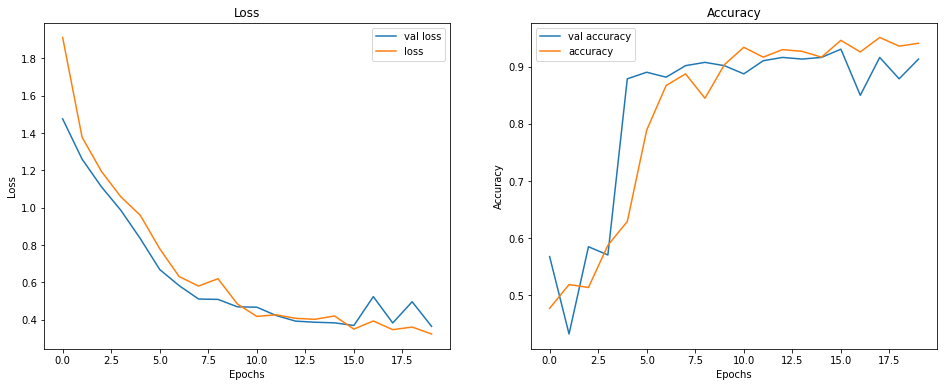

In [201]:
visualize_training_results(history_model4)

In [202]:
results_test4 = model4.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test4[1]}")

20/20 [==============================] - 0s 2ms/step - loss: 0.5276 - accuracy: 0.8558
Test set results accuracy 0.8557692170143127


### Baseline + regulization + Dropout + Adam optimizer + increased train time

In [206]:
model5 = models.Sequential()
model5.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model5.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model5.add(layers.Dense(1, activation='sigmoid'))

In [208]:
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_model5 = model5.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=50,
                    validation_data=(val_img, val_y))

Epoch 1/50
20/20 [==============================] - 1s 14ms/step - loss: 0.5072 - accuracy: 0.8865 - val_loss: 0.4759 - val_accuracy: 0.8818
Epoch 2/50
20/20 [==============================] - 0s 9ms/step - loss: 0.3817 - accuracy: 0.9402 - val_loss: 0.3892 - val_accuracy: 0.9251
Epoch 3/50
20/20 [==============================] - 0s 10ms/step - loss: 0.3239 - accuracy: 0.9544 - val_loss: 0.4017 - val_accuracy: 0.9193
Epoch 4/50
20/20 [==============================] - 0s 9ms/step - loss: 0.3124 - accuracy: 0.9453 - val_loss: 0.3855 - val_accuracy: 0.9222
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.2848 - accuracy: 0.9625 - val_loss: 0.4071 - val_accuracy: 0.9107
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.3254 - accuracy: 0.9433 - val_loss: 0.3887 - val_accuracy: 0.9107
Epoch 7/50
20/20 [==============================] - 0s 9ms/step - loss: 0.3167 - accuracy: 0.9463 - val_loss: 0.3499 - val_accuracy: 0.9251
Epoch 8/50
20/20 [

In [209]:
results_train5 = model5.evaluate(train_img, train_y)

31/31 [==============================] - 0s 2ms/step - loss: 0.1662 - accuracy: 0.9828


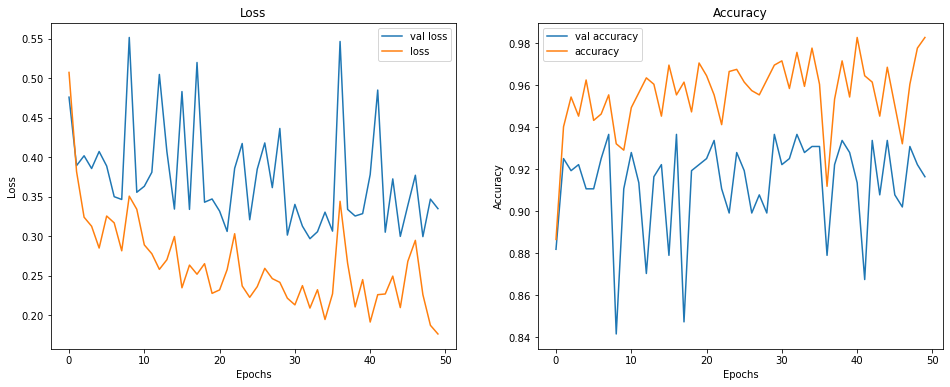

In [210]:
visualize_training_results(history_model5)

In [212]:
results_test5 = model5.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test5[1]}")

20/20 [==============================] - 0s 2ms/step - loss: 0.6334 - accuracy: 0.8381
Test set results accuracy 0.8381410241127014


### CNN_1, shape 64

In [227]:
model_CNN = models.Sequential()
model_CNN.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Flatten())
model_CNN.add(layers.Dense(30, activation='relu'))
model_CNN.add(layers.Dense(10, activation='relu'))
model_CNN.add(layers.Dense(1, activation='sigmoid'))

model_CNN.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [228]:
history_CNN1 = model_CNN.fit(train_images,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/25
31/31 [==============================] - 4s 123ms/step - loss: 0.6916 - accuracy: 0.4762 - val_loss: 0.6893 - val_accuracy: 0.4323
Epoch 2/25
31/31 [==============================] - 4s 117ms/step - loss: 0.6812 - accuracy: 0.5370 - val_loss: 0.6824 - val_accuracy: 0.4438
Epoch 3/25
31/31 [==============================] - 4s 127ms/step - loss: 0.6675 - accuracy: 0.6505 - val_loss: 0.6885 - val_accuracy: 0.4323
Epoch 4/25
31/31 [==============================] - 4s 134ms/step - loss: 0.6475 - accuracy: 0.7021 - val_loss: 0.6616 - val_accuracy: 0.4726
Epoch 5/25
31/31 [==============================] - 4s 136ms/step - loss: 0.6235 - accuracy: 0.7568 - val_loss: 0.6313 - val_accuracy: 0.7349
Epoch 6/25
31/31 [==============================] - 4s 142ms/step - loss: 0.5959 - accuracy: 0.7315 - val_loss: 0.5673 - val_accuracy: 0.8156
Epoch 7/25
31/31 [==============================] - 5s 146ms/step - loss: 0.5401 - accuracy: 0.7730 - val_loss: 0.6527 - val_accuracy: 0.5014
Epoch 

In [229]:
results_test = model_CNN.evaluate(test_images, test_y)

20/20 [==============================] - 1s 35ms/step - loss: 0.4146 - accuracy: 0.8542


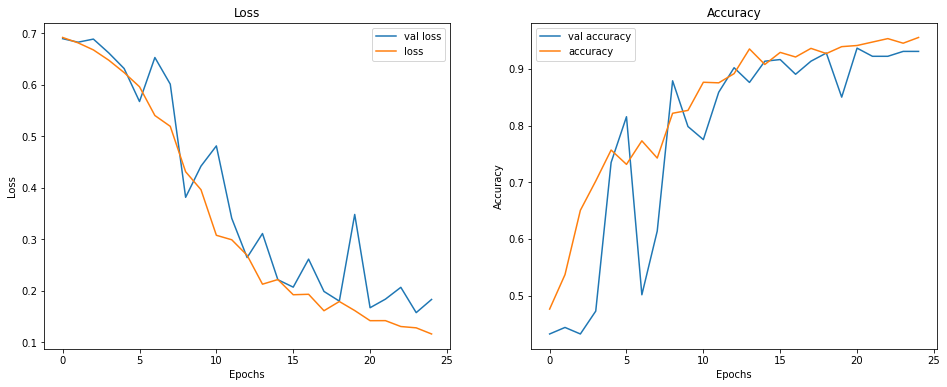

In [230]:
visualize_training_results(history_CNN1)

### CNN_2, shape 64 + dropout + regulization

In [238]:
model_CNN2 = models.Sequential()
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Flatten())
model_CNN2.add(layers.Dense(40, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model_CNN2.add(layers.Dropout(0.2))
model_CNN2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [239]:
history_CNN2 = model_CNN2.fit(train_images,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/25
31/31 [==============================] - 15s 396ms/step - loss: 1.0909 - accuracy: 0.6363 - val_loss: 0.7661 - val_accuracy: 0.8127
Epoch 2/25
31/31 [==============================] - 10s 330ms/step - loss: 0.6689 - accuracy: 0.7629 - val_loss: 0.4286 - val_accuracy: 0.9078
Epoch 3/25
31/31 [==============================] - 10s 319ms/step - loss: 0.4148 - accuracy: 0.8916 - val_loss: 0.3339 - val_accuracy: 0.9280
Epoch 4/25
31/31 [==============================] - 11s 350ms/step - loss: 0.3534 - accuracy: 0.9200 - val_loss: 0.4642 - val_accuracy: 0.8732
Epoch 5/25
31/31 [==============================] - 11s 340ms/step - loss: 0.3107 - accuracy: 0.9362 - val_loss: 0.3711 - val_accuracy: 0.8934
Epoch 6/25
31/31 [==============================] - 11s 352ms/step - loss: 0.3033 - accuracy: 0.9281 - val_loss: 0.2926 - val_accuracy: 0.9280
Epoch 7/25
31/31 [==============================] - 10s 332ms/step - loss: 0.2676 - accuracy: 0.9463 - val_loss: 0.2388 - val_accuracy: 0.9424

In [240]:
results_test = model_CNN2.evaluate(test_images, test_y)

20/20 [==============================] - 1s 68ms/step - loss: 0.6140 - accuracy: 0.8462


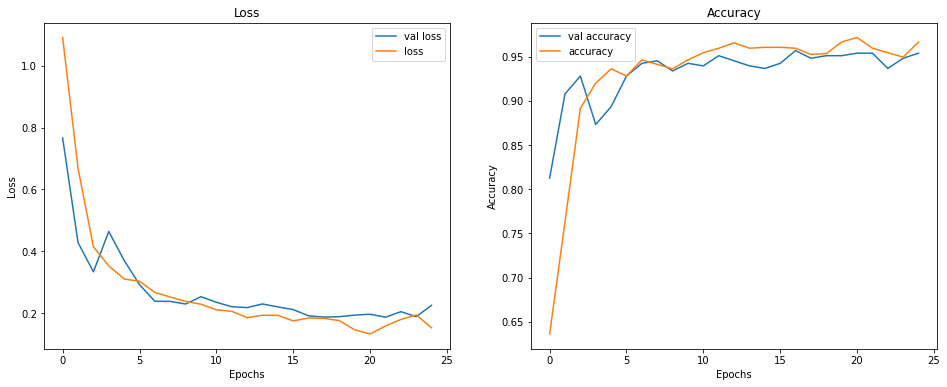

In [241]:
visualize_training_results(history_CNN2)

### CNN_3, shape 100 + dropout + regulization

In [261]:
# get all the data in the directory split/train, and reshape them
train_generator_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(100, 100), batch_size= train_img_number)

# get all the data in the directory split/validation, and reshape them
val_generator_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(100, 100), batch_size = val_img_number)

# get all the data in the directory split/test, and reshape them
test_generator_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(100, 100), batch_size = test_img_number) 

train_images2, train_labels2 = next(train_generator_100)
test_images2, test_labels2 = next(test_generator_100)
val_images2, val_labels2 = next(val_generator_100)


Found 987 images belonging to 2 classes.
Found 347 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
test_generator_100

In [262]:
train_images2.shape

(987, 100, 100, 3)

In [263]:
train_img2 = train_images2.reshape(train_images2.shape[0], -1)
test_img2 = test_images2.reshape(test_images2.shape[0], -1)
val_img2 = val_images2.reshape(val_images2.shape[0], -1)

print(train_img2.shape)
print(test_img2.shape)
print(val_img2.shape)

(987, 30000)
(624, 30000)
(347, 30000)


In [264]:
train_y2 = np.reshape(train_labels[:,0], (train_img_number,1))
test_y2 = np.reshape(test_labels[:,0], (test_img_number,1))
val_y2 = np.reshape(val_labels[:,0], (val_img_number,1))

In [270]:
model_CNN3 = models.Sequential()
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Flatten())
model_CNN3.add(layers.Dense(30, activation='relu'))
model_CNN3.add(layers.Dense(10, activation='relu'))
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [ ]:
history_CNN3 = model_CNN3.fit(train_images2,
                    train_y2,
                    epochs=25,
                    batch_size=50,
                    validation_data=(val_images2, val_y2))

Epoch 1/25
20/20 [==============================] - 8s 351ms/step - loss: 0.6923 - accuracy: 0.5238 - val_loss: 0.6897 - val_accuracy: 0.5677
Epoch 2/25
20/20 [==============================] - 8s 390ms/step - loss: 0.6923 - accuracy: 0.5238 - val_loss: 0.6896 - val_accuracy: 0.5677
Epoch 3/25
20/20 [==============================] - 8s 410ms/step - loss: 0.6923 - accuracy: 0.5238 - val_loss: 0.6894 - val_accuracy: 0.5677
Epoch 4/25
20/20 [==============================] - 9s 439ms/step - loss: 0.6922 - accuracy: 0.5238 - val_loss: 0.6891 - val_accuracy: 0.5677
Epoch 5/25
20/20 [==============================] - 9s 455ms/step - loss: 0.6921 - accuracy: 0.5238 - val_loss: 0.6889 - val_accuracy: 0.5677
Epoch 6/25
20/20 [==============================] - 10s 522ms/step - loss: 0.6921 - accuracy: 0.5238 - val_loss: 0.6888 - val_accuracy: 0.5677
Epoch 7/25
20/20 [==============================] - 11s 538ms/step - loss: 0.6921 - accuracy: 0.5238 - val_loss: 0.6887 - val_accuracy: 0.5677
Epoc

In [248]:
# model_CNN3 = models.Sequential()
# model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(299 ,299, 3)))
# model_CNN3.add(layers.MaxPooling2D((2, 2)))

# model_CNN3.add(layers.Conv2D(32, (4, 4), activation='relu'))
# model_CNN3.add(layers.MaxPooling2D((2, 2)))

# model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model_CNN3.add(layers.MaxPooling2D((2, 2)))

# model_CNN3.add(layers.Flatten())
# model_CNN3.add(layers.Dense(40, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
# model_CNN3.add(layers.Dropout(0.2))
# model_CNN3.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
# model_CNN3.add(layers.Dense(1, activation='sigmoid'))

# model_CNN3.compile(loss='binary_crossentropy',
#               optimizer="Adam",
#               metrics=['accuracy'])

In [250]:
# history_CNN3 = model_CNN3.fit(train_images2,
#                     train_y2,
#                     epochs=10,
#                     batch_size=32,
#                     validation_data=(val_images2, val_y2))

Epoch 1/10
31/31 [==============================] - 76s 2s/step - loss: 0.9161 - accuracy: 0.4883 - val_loss: 0.8594 - val_accuracy: 0.5677
Epoch 2/10
31/31 [==============================] - 76s 2s/step - loss: 0.8340 - accuracy: 0.5238 - val_loss: 0.8105 - val_accuracy: 0.5677
Epoch 3/10
31/31 [==============================] - 82s 3s/step - loss: 0.8006 - accuracy: 0.5238 - val_loss: 0.7835 - val_accuracy: 0.5677
Epoch 4/10
31/31 [==============================] - 75s 2s/step - loss: 0.7751 - accuracy: 0.5238 - val_loss: 0.7600 - val_accuracy: 0.5677
Epoch 5/10
31/31 [==============================] - 77s 2s/step - loss: 0.7663 - accuracy: 0.5238 - val_loss: 0.7559 - val_accuracy: 0.5677
Epoch 6/10
31/31 [==============================] - 78s 3s/step - loss: 0.7492 - accuracy: 0.5238 - val_loss: 0.7382 - val_accuracy: 0.5677
Epoch 7/10
31/31 [==============================] - 88s 3s/step - loss: 0.7364 - accuracy: 0.5238 - val_loss: 0.7332 - val_accuracy: 0.5677
Epoch 8/10
31/31 [==

### CNN_3, shape 299 + dropout + regulization


In [254]:
from keras.applications.xception import Xception
cnn_base = Xception(weights='imagenet',  
                 input_shape=(299, 299, 3))

91897856/91884032 [==============================] - 7s 0us/step


In [255]:
cnn_base.compile(loss='binary_crossentropy',
               optimizer="Adam",
               metrics=['accuracy'])

In [260]:
cnn_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [256]:
history_CNN4 = cnn_base.fit(train_images2,
                    train_y2,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images2, val_y2))

Epoch 1/10


ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 1932, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 5247, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1000) vs (None, 1)).


# Conclusion
---
For our finalized model we used LinearRegression because of the following reasons: 
1) It is easy to interprete.

2) It have good recall compared to the other models, without much sacrifice in precision. 


Overall, this data tells us that injuries during car crashes can be predicted and we can see tha major factors that influence it. These modeling results correspond to our observations during data exploration phase